# HCL Stock Price Forecasting:

##### About dataset:
The dataset consists of stock market data of HCL. and it can be downloaded from finance.yahoo.

The data shows the stock price of HCL from 2017–04–21 till 2022–04–21. The goal is to train an ARIMA model with optimal parameters that will forecast the closing price of the stocks on the test data.

In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [2]:
#import dataset

data1=pd.read_csv(r'C:\Users\Malyaj Mishra\Desktop\DS_IT\Projects\Time_series\HCLTECH.csv')

In [3]:
data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-21,408.500000,410.725006,403.899994,406.375000,361.817200,1780310
1,2017-04-24,406.500000,412.000000,404.625000,409.774994,364.844421,1373968
2,2017-04-25,412.000000,412.924988,406.799988,409.975006,365.022522,2194602
3,2017-04-26,410.950012,411.000000,398.274994,400.125000,356.252502,1918248
4,2017-04-27,398.500000,410.000000,398.100006,404.850006,360.459381,5640334


In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1235 non-null   object 
 1   Open       1235 non-null   float64
 2   High       1235 non-null   float64
 3   Low        1235 non-null   float64
 4   Close      1235 non-null   float64
 5   Adj Close  1235 non-null   float64
 6   Volume     1235 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 67.7+ KB


### Basic pre-processing of our time series data:

In [5]:
#change date to datetime format:

from datetime import datetime as dt

def convert(x):
    return dt.strptime(x, '%Y-%m-%d')
data1['Date']=data1['Date'].transform(lambda f:convert(f))

In [6]:
#take out only "Date" and "Adj Close" column
#making date column as index

data1=data1[["Date", "Adj Close"]]
data1.index=data1['Date']
data1=data1.drop(['Date'],axis=1)
data1=data1.sort_index()


In [7]:
data1.head()

,Adj Close
Date,
2017-04-21,361.817200
2017-04-24,364.844421
2017-04-25,365.022522
2017-04-26,356.252502
2017-04-27,360.459381


In [8]:
data1.tail()

,Adj Close
Date,
2022-04-12,1089.306519
2022-04-13,1083.480225
2022-04-18,1060.994019
2022-04-19,1030.659180
2022-04-20,1049.100830


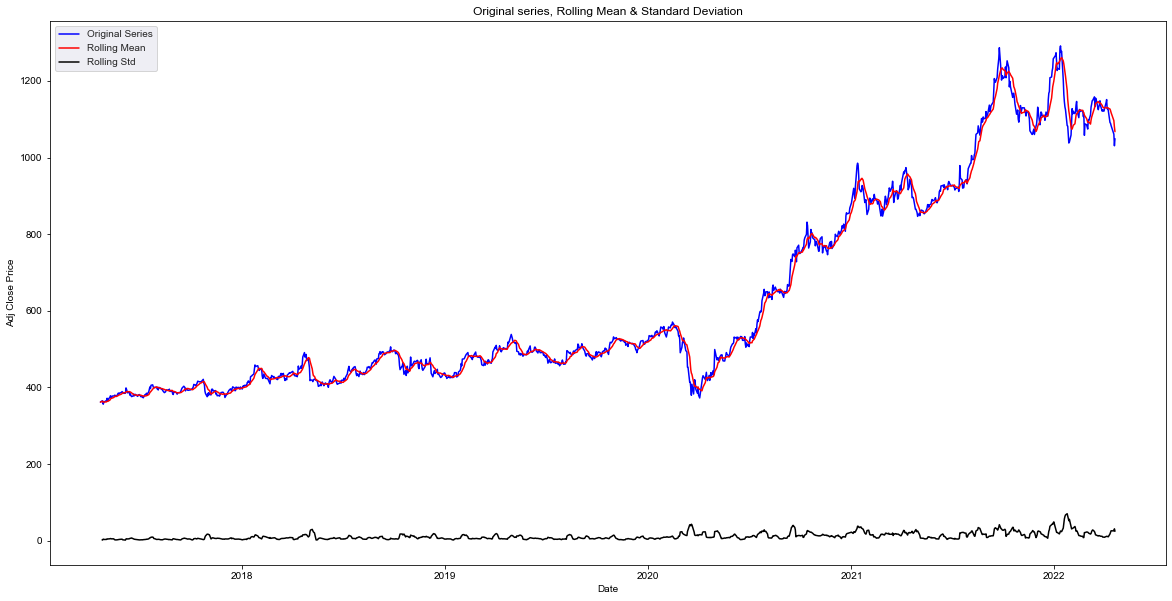

Augument Dickey Fuller test results:
Test Statistics                  -0.551012
p-value                           0.881672
No. of lags used                  7.000000
Number of observations used    1227.000000
Critical value (1%)              -3.435691
Critical value (5%)              -2.863898
Critical value (10%)             -2.568026
dtype: float64

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [9]:
#Function for visualizing data & finding out its stationarity using rolling plots & adfuller test(adft):

def test_stationarity(ts):
    #Finding rolling statistics
    rolmean = ts.rolling(window='12D').mean()
    rolstd = ts.rolling(window='12D').std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    sns.set_style('darkgrid')
    plt.plot(ts, color='blue',label='Original Series')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Original series, Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print("Augument Dickey Fuller test results:")
    adft = adfuller(ts,autolag='AIC')
    #Output for adft will give us values but without defining what the values are!!!
    #So we manually write what values it'll give as outputs.
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,value in adft[4].items():
        output['Critical value (%s)'%key] =  value
    print(output)
    
    if adft[1] <= 0.05: #if p value less than 5%
        print("\nStrong evidence against null hypothesis, reject the null hypothesis. Time series has no unit root and is stationary.")
    else:
        print("\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")
    
    

test_stationarity(data1)



<Figure size 432x288 with 0 Axes>

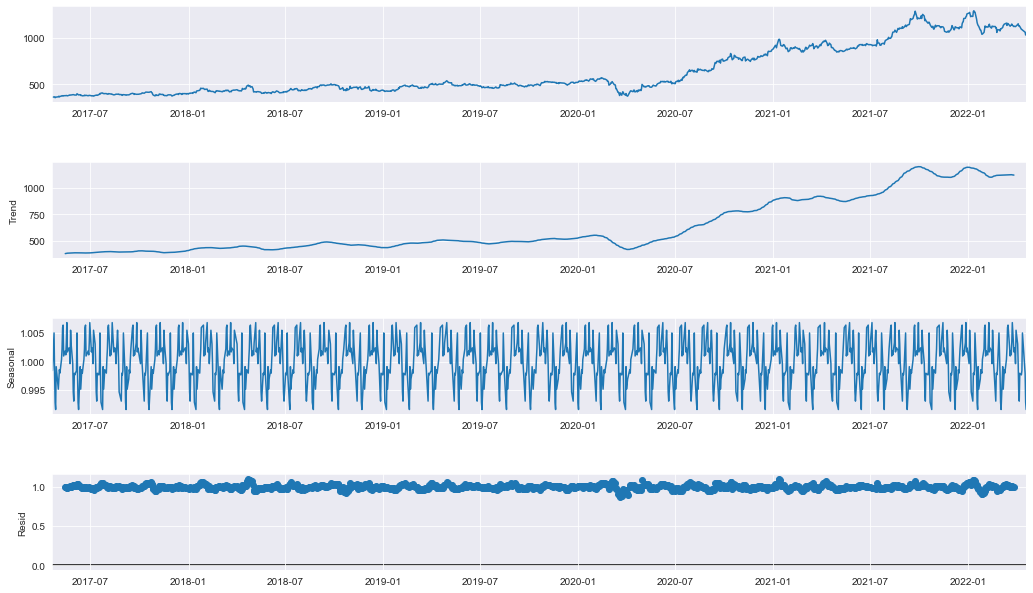

In [10]:
#Separating trend, seasonality of time series(decomposing):

decomposition = seasonal_decompose(data1,model='multiplicative',period=30)
fig=plt.figure()
sns.set_style('darkgrid')
fig=decomposition.plot()
fig.set_size_inches(16,9)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


### Converting our non-stationary series to stationary time series:

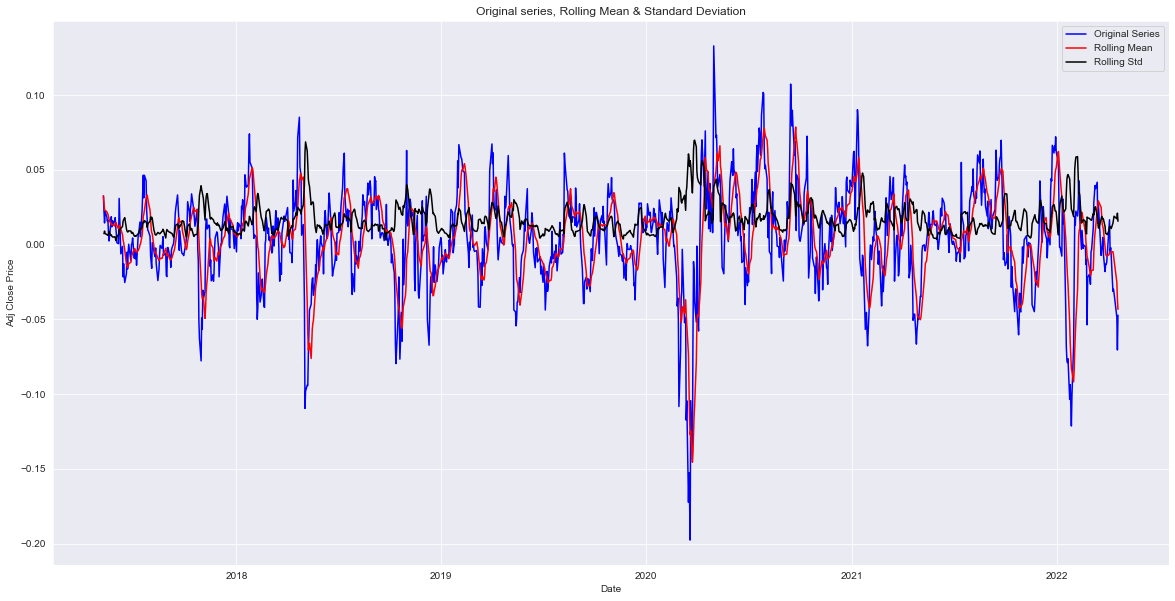

Augument Dickey Fuller test results:
Test Statistics               -7.933412e+00
p-value                        3.464312e-12
No. of lags used               2.300000e+01
Number of observations used    1.200000e+03
Critical value (1%)           -3.435811e+00
Critical value (5%)           -2.863952e+00
Critical value (10%)          -2.568054e+00
dtype: float64

Strong evidence against null hypothesis, reject the null hypothesis. Time series has no unit root and is stationary.


In [11]:
#Converting/Transforming non-stationary to stationary data
#There are many methods for it. We will use one of them---> Taking log then subtracting with moving average.

from pylab import rcParams

rcParams['figure.figsize']= 20,10
data_adj_close_log=np.log(data1['Adj Close'])
moving_average=data_adj_close_log.rolling(12).mean()


#subtracting moving avg from 'Adj close' to complete our transformation process for making series stationary.
data_log_minus_mean = data_adj_close_log - moving_average
data_log_minus_mean.dropna(inplace= True)   #first 11 values will be NAN as we took set of 12 to find moving avg.

test_stationarity(data_log_minus_mean)



In [12]:
#Checking changes created due to transformation of time series data

print(len(data_adj_close_log))
print(len(data_log_minus_mean))
print(data_log_minus_mean)

1235
1224
Date
2017-05-09    0.032623
2017-05-10    0.022254
2017-05-11    0.014504
2017-05-12    0.022350
2017-05-15    0.018528
                ...   
2022-04-12   -0.029841
2022-04-13   -0.032375
2022-04-18   -0.048503
2022-04-19   -0.070427
2022-04-20   -0.047190
Name: Adj Close, Length: 1224, dtype: float64


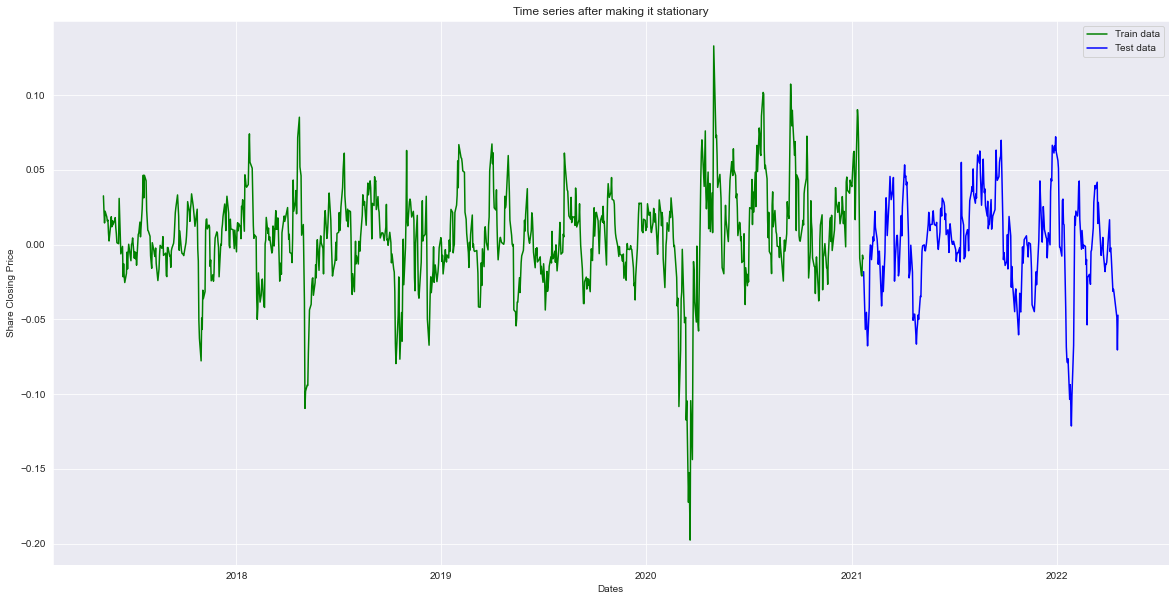

In [13]:
#splitting data into train, test and visualizing after making it stationary
#doing a 75:25 split

train_data, test_data= data_log_minus_mean[:int(len(data_log_minus_mean)*0.75)], data_log_minus_mean[int(len(data_log_minus_mean)*0.75):]
plt.figure(figsize=(20,10))
plt.xlabel("Dates")
plt.ylabel("Share Closing Price")
plt.title("Time series after making it stationary")
sns.set_style('darkgrid')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


In [14]:
test_data.head()

Date
2021-01-22   -0.018054
2021-01-25   -0.056701
2021-01-27   -0.045281
2021-01-28   -0.058263
2021-01-29   -0.067676
Name: Adj Close, dtype: float64

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3665.012, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4878.018, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4323.993, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4876.860, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4876.844, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4874.778, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4878.235, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3690.050, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-4876.956, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4876.939, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4340.960, Time=1.50 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4874.780, Time=1.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 5.938 seconds
                               SARIMAX Results                              

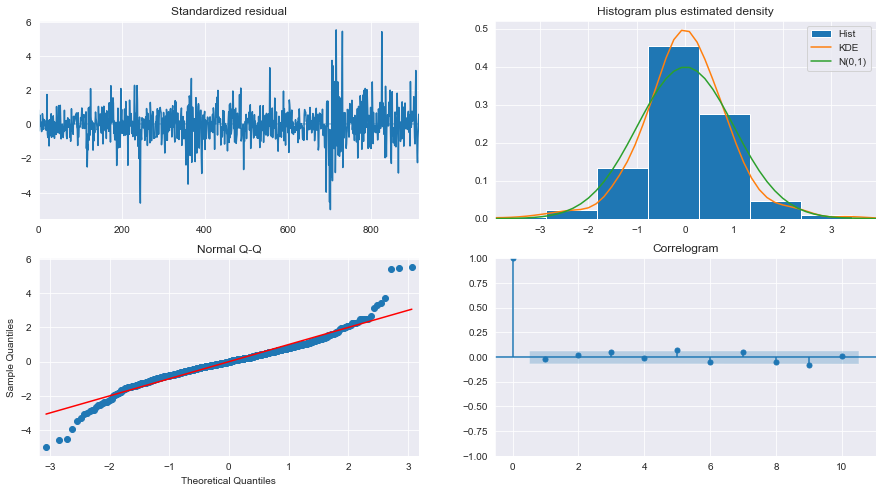

In [15]:
#auto ARIMA

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

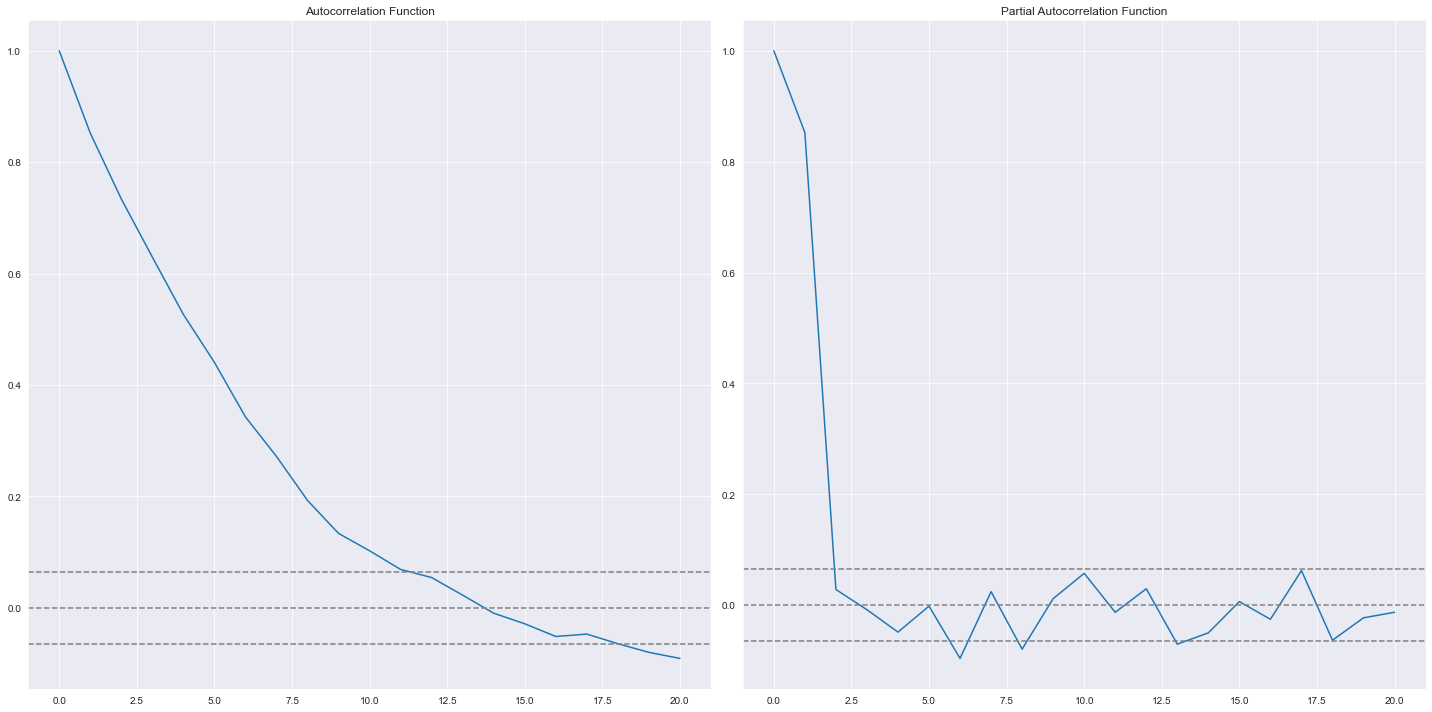

In [16]:
#Finding optimal order values for ARIMA model using acf and pacf:

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_data, nlags=20)
lag_pacf = pacf(train_data, nlags=20, method='ols')
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_data)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_data)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_data)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_data)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


(0.0, 20.0)

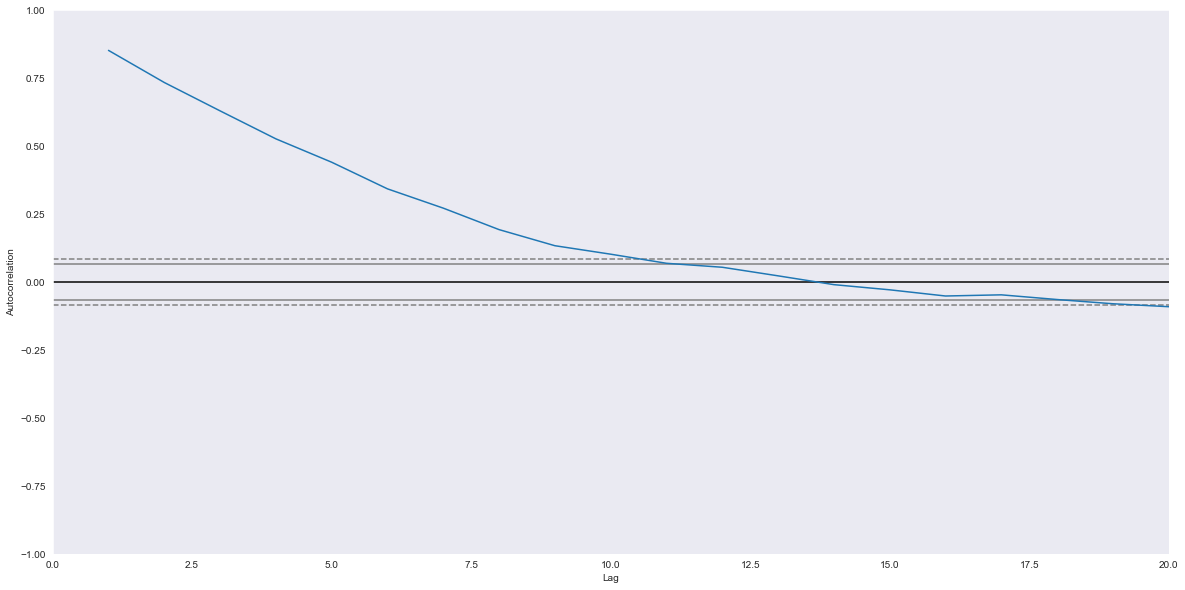

In [17]:
#Plotting acf function
pd.plotting.autocorrelation_plot(train_data)
plt.xlim([0, 20])

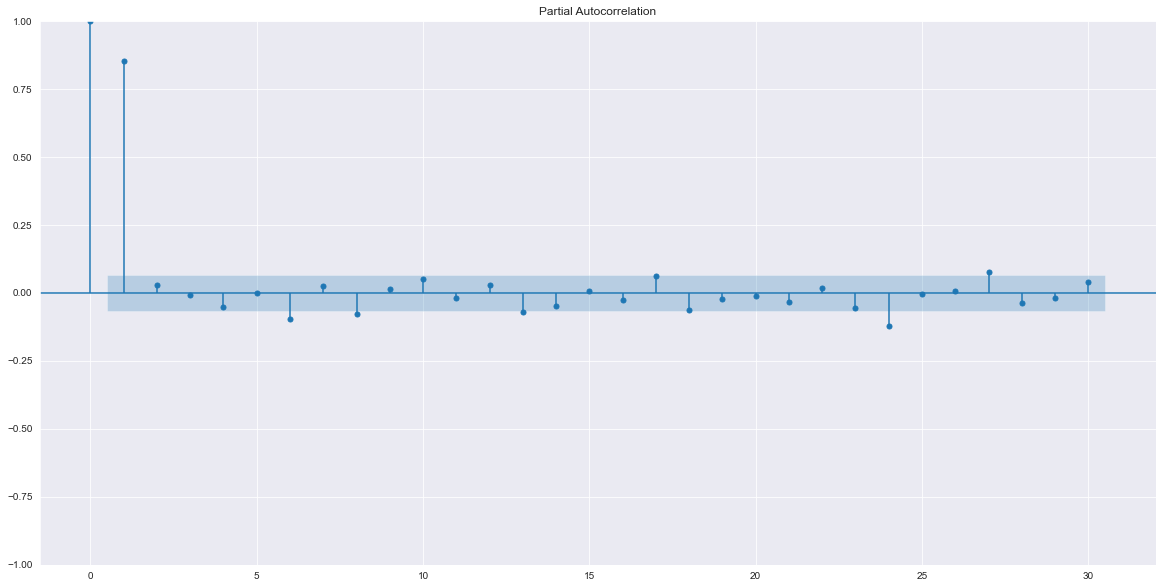

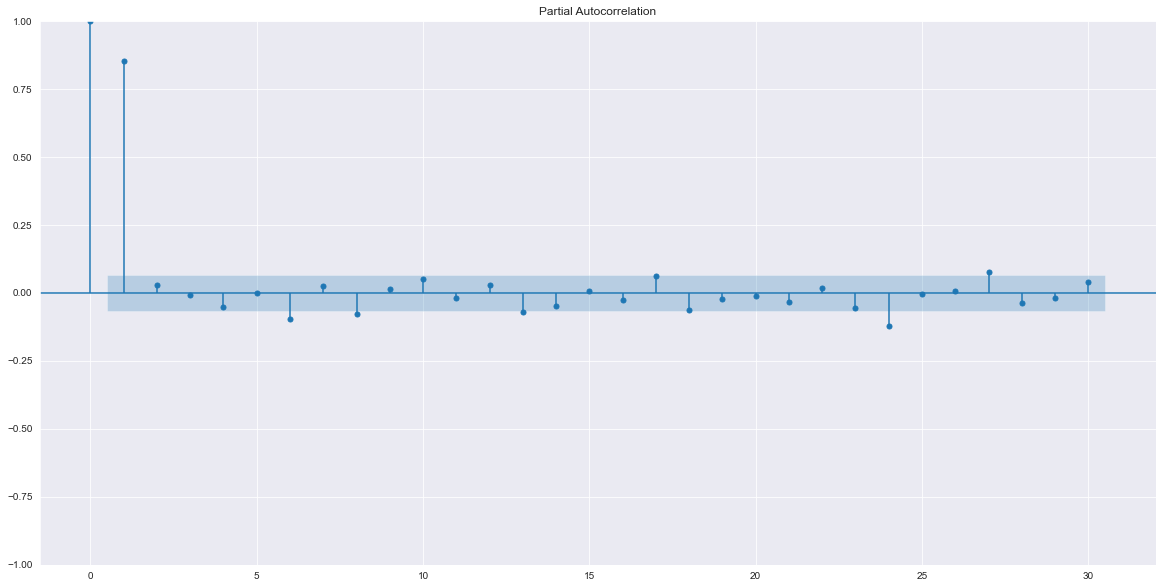

In [18]:
#Plotting pacf function
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data, lags = 30)

In [19]:
p,d,q=1,0,0

In [20]:
#ARIMA model

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1,0,0))   #p,d,q=1,0,0
results_ARIMA = model.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  918
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2442.117
Date:                Thu, 17 Nov 2022   AIC                          -4878.235
Time:                        20:49:07   BIC                          -4863.768
Sample:                             0   HQIC                         -4872.714
                                - 918                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.004      1.438      0.150      -0.002       0.013
ar.L1          0.8524      0.010     81.659      0.000       0.832       0.873
sigma2         0.0003   7.28e-06     39.260      0.0

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


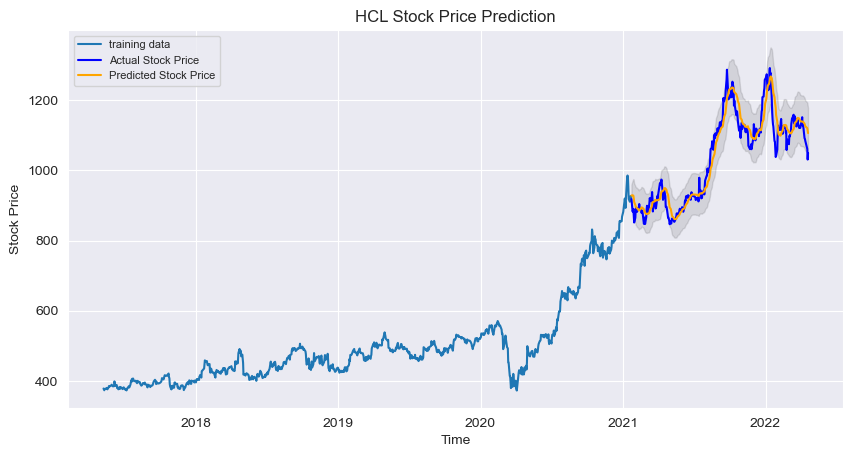

In [21]:
#Forecasting and plotting results:

#Forecasting 
fc= results_ARIMA.get_forecast(len(test_data), alpha=0.05)      # alpha=0.05; 95% conf
#len(test_data) = no. of samples to be forecasted.


fc_series = fc.predicted_mean               #fc_series=forecast 
pred_conf_int = fc.conf_int(alpha=0.05)     #pred_conf_int=dataframe of the confidence interval for the forecast


fc_series.index=test_data.index
pred_conf_int.index=test_data.index

#changing our time series forecast to original version(undoing the transformation)
final_forecast= fc_series + moving_average
final_forecast = np.exp(final_forecast)
final_forecast.dropna(inplace= True)


#Extracting prediction confidence intervals & transforming back to original version.
lower_series= np.exp(pred_conf_int.iloc[:,0] + moving_average)
lower_series.dropna(inplace= True)
upper_series= np.exp(pred_conf_int.iloc[:,1] + moving_average)
upper_series.dropna(inplace= True)



#for plotting the original time series data showing train,test split.
k=len(data1['Adj Close'])-len(data_log_minus_mean)
#Since we need to remove first k=11 samples from original data to align it with results.
plot_data=data1.iloc[k:] 
train1, test1= plot_data['Adj Close'][:int(len(plot_data)*0.75)], plot_data['Adj Close'][int(len(plot_data)*0.75):]


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train1, label='training data')
plt.plot(test1, color = 'blue', label='Actual Stock Price')
plt.plot(final_forecast, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)



plt.title('HCL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
#Forecasted values vs actual values

print("Final forecast values:\n",final_forecast)
print("\nActual Stock values:\n",test1)

Final forecast values:
 Date
2021-01-22     928.089470
2021-01-25     928.943641
2021-01-27     927.650058
2021-01-28     919.844327
2021-01-29     909.777649
                 ...     
2022-04-12    1128.598922
2022-04-13    1125.410689
2022-04-18    1119.971629
2022-04-19    1112.066480
2022-04-20    1105.965010
Length: 306, dtype: float64

Actual Stock values:
 Date
2021-01-22     918.132629
2021-01-25     882.461670
2021-01-27     889.912598
2021-01-28     869.841797
2021-01-29     851.261169
                 ...     
2022-04-12    1089.306519
2022-04-13    1083.480225
2022-04-18    1060.994019
2022-04-19    1030.659180
2022-04-20    1049.100830
Name: Adj Close, Length: 306, dtype: float64


In [23]:
# Model performance metrics

mse = mean_squared_error(test_data, fc_series)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc_series)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
print('RMSE: '+str(rmse))
rmspe = np.sqrt(np.mean(np.square(((test_data - fc_series) / test_data)), axis=0))
print('RMSPE: '+str(rmspe))

MSE: 0.0010635447084298398
MAE: 0.024534913713814617
RMSE: 0.03261203318454462
RMSPE: 9.299820195202825
